In [1]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt

from cvxopt import solvers,matrix
from matplotlib.colors import ListedColormap
solvers.options['show_progress']=False
import seaborn as sns;

In [4]:
def plot_policy_map(table, val, title=""):
    
    plt.pcolor(table, cmap=ListedColormap(['white']), edgecolors='black')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    for y in range(table.shape[0]):
        for x in range(table.shape[1]):
            plt.text(x + 0.5, y + 0.5, val[y, x],
                horizontalalignment='center',
                verticalalignment='center')
    plt.show()
    
    
def plot_optimal_policy_diff(P,title="",diff_list=[]):
    U=np.chararray((P.shape[0], P.shape[1]),unicode=True)
    
    for r in range(P.shape[0]):
        for c in range(P.shape[1]):
            if ((r,c) in diff_list):
                U[r][c] = arrows[P[r][c]]
    plot_policy_map(P, U, title)
    
def probability(currentstate, nextstate, move, prob):
    actions = [-10, -1, 10, 1]
    left = currentstate + actions[0]
    up = currentstate + actions[1]
    right = currentstate + actions[2]
    down = currentstate + actions[3]
    if nextstate == left:
        if move == 0:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextstate == up:
        if move == 1:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextstate == right:
        if move == 2:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextstate == down:
        if move == 3:
            return 1-prob+prob/4
        else:
            return prob/4
    elif nextstate == currentstate:
        record = 0
        if left < 0:
            if move == 0:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if right > 99:
            if move == 2:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if up % 10 == 9:
            if move == 1:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        if down % 10 == 0:
            if move == 3:
                record += (1-prob+prob/4)
            else:
                record += prob/4
        return record
    else:
        return 0
    
def next_states(length, cur_state):
    x = cur_state % length
    y = cur_state // length
    up = cur_state - 1
    down = cur_state + 1
    left = cur_state - length
    right = cur_state + length
    if x == 0:
        up = cur_state
    if x == length - 1:
        down = cur_state
    if y == 0:
        left = cur_state
    if y == length - 1:
        right = cur_state
    return np.array([up, down, left, right])

def compute(currentstate, move, prob, gamma, reward, values):
    left = currentstate + actions[0]
    right = currentstate + actions[2]
    up = currentstate + actions[1]
    down = currentstate + actions[3]
    neighbours = [left, right, up, down, currentstate]
    result = 0
    for neigh in neighbours:
        if neigh < 0 or neigh > 99 or (currentstate % 10 == 0 and neigh % 10 == 9) or (currentstate % 10 == 9 and neigh % 10 == 0):
            continue
        result += probability(currentstate, neigh, move, prob) * (reward[neigh] + gamma * values[neigh])
    return result

def optimal_state_val(w, gamma, reward, threshold):
    values = [0 for _ in range(100)]
    for state in range(100):
        values[state] = 0
    delta = float('inf')
    while delta > threshold:
        delta = 0
        temp = values[:]
        for state in range(100):
            v = values[state]
            values[state] = max(compute(state, 0, w, gamma, reward, temp),
                                compute(state, 1, w, gamma, reward, temp),
                                compute(state, 2, w, gamma, reward, temp),
                                compute(state, 3, w, gamma, reward, temp))
            delta = max(delta, abs(v - values[state]))
    return values

def raw_matrix(length, w, direction):
    s = length * length
    res = np.zeros(s * s).reshape(s, s)
    main_possibility = 1 - w
    random_possibility = w / 4
    for row in range(s):
        nexts = next_states(length, row)
        if direction == "up":
            res[row][nexts[0]] = main_possibility
        elif direction == "down":
            res[row][nexts[1]] = main_possibility
        elif direction == "left":
            res[row][nexts[2]] = main_possibility
        elif direction == "right":
            res[row][nexts[3]] = main_possibility
        for col in nexts:
            res[row][col] += random_possibility
    return res


def get_reward(c, D, b):
    A = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    sol=solvers.lp(c,A,b)
    return sol['x'][-100:]

def get_c_D_b(exp_action, P_actions, lam, rmax):
    # create P_exp(P_a1), P_ag1(P_a), P_ag2(P_a), P_ag3(P_a)
    P_exp = []
    P_ags = []
    P_ags.append([])
    P_ags.append([])
    P_ags.append([])
    for state in range(100):
        exp_act = exp_action[state]
        agent = 0
        for action in range(4):
            if action == exp_act:
                P_exp.append(P_actions[action][state])
            else:
                P_ags[agent].append(P_actions[action][state])
                agent += 1

    I = np.eye(100)
    zero = np.zeros(100 * 100).reshape(100, 100)
    D = np.concatenate((zero, zero, zero, zero))
    D = np.concatenate((D, np.concatenate((-I, -I, zero, zero)), 
                        np.concatenate((I, -I, I, -I))), 1)
 
    for Pa in P_ags:
        # (Pa-Pa1)(I-ga*Pa1)^(-1)
        temp = np.dot((np.array(Pa) - np.array(P_exp)), 
                      np.linalg.inv(np.eye(100) - 0.8 * np.array(P_exp)))
        temp_row1 = np.concatenate((I, zero, temp), 1)
        temp_row2 = np.concatenate((zero, zero, temp), 1)
        temp = np.concatenate((temp_row1, temp_row2))
        D = np.concatenate((temp, D))
        
    c1 = np.array([1. for _ in range(100)])
    c2 = np.array([-lam for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)
    c = -c
    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([rmax for _ in range(200)])
    b = np.concatenate((b1, b2), axis=0)
    return c, D, b

In [6]:
reward2 = [[0 for _ in range(10)] for _ in range(10)]
reward2[1][4:7] = [-100 for _ in range(3)]
reward2[2][4] = -100
reward2[2][6] = -100
reward2[3][4] = -100
reward2[3][6:9] = [-100 for _ in range(3)]
reward2[4][4] = -100
reward2[4][8] = -100
reward2[5][4] = -100
reward2[5][8] = -100
reward2[6][4] = -100
reward2[6][8] = -100
reward2[7][6:9] = [-100 for _ in range(3)]
reward2[8][6] = -100
reward2[9][9] = 10
reward_2 = []
reward2 = np.array(reward2).transpose()
for lines in reward2:
    reward_2 += list(lines)

In [5]:
thres = 0.01
actions = [-10, -1, 10, 1]
w = 0.1
gamma = 0.8

In [7]:
v_2_flat = optimal_state_val(w, gamma, reward_2, thres)
exp_action2 = [0 for _ in range(100)]
for state in range(100):
    exp_action2[state] = np.argmax([compute(state, 0, w, gamma, reward_2, v_2_flat),
                                   compute(state, 1, w, gamma, reward_2, v_2_flat),
                                   compute(state, 2, w, gamma, reward_2, v_2_flat),
                                   compute(state, 3, w, gamma, reward_2, v_2_flat)])
v_2 = np.reshape(v_2_flat, (10,10)).T

In [8]:
P_acts = []
P_acts.append(raw_matrix(10, 0.1, "left"))
P_acts.append(raw_matrix(10, 0.1, "up"))
P_acts.append(raw_matrix(10, 0.1, "right"))
P_acts.append(raw_matrix(10, 0.1, "down"))

lam_max2 = 0.77
c_opt2, D_opt2, b_opt2 = get_c_D_b(exp_action2, P_acts, lam_max2, 100)
reward_opt2 = np.array(get_reward(c_opt2, D_opt2, b_opt2))

v_maxlambda_2_flat = optimal_state_val(w, gamma, reward_opt2, thres)
v_maxlambda_2 = np.reshape(v_maxlambda_2_flat, (10,10)).T

Text(0.5, 1.0, 'Values from Value Iteration for Reward 2')

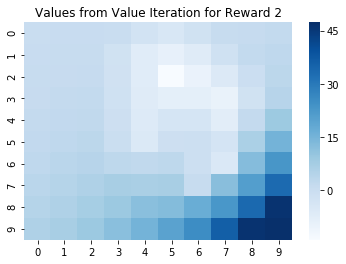

In [9]:
# Heat Map from Q7
# Optimal Value for Each State from Value Iteration using Reward 2

ax = sns.heatmap(v_2, cmap="Blues")
ax.set_title("Values from Value Iteration for Reward 2")

Text(0.5, 1.0, 'Values from Value Iteration for Predicted Reward 2')

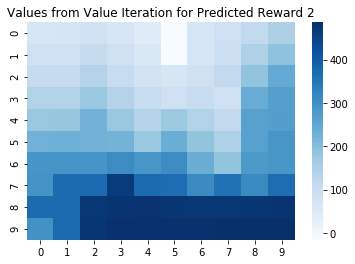

In [10]:
# Question 22
# Optimal Value for Each State from Value Iteration using the Predicted Reward from IRL

ax = sns.heatmap(v_maxlambda_2, cmap="Blues")
ax.set_title("Values from Value Iteration for Predicted Reward 2")

In [11]:
arrows = ['\u2190', '\u2191', '\u2192', '\u2193']

In [13]:
p_maxlambda_2 = [0 for _ in range(100)]
p_maxlambda_2_u = [0 for _ in range(100)]
for state in range(100):
    p_maxlambda_2[state] = np.argmax([compute(state, 0, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 1, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 2, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 3, w, gamma, reward_opt2, v_maxlambda_2_flat)])
    p_maxlambda_2_u[state] = arrows[np.argmax([compute(state, 0, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 1, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 2, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 3, w, gamma, reward_opt2, v_maxlambda_2_flat)])]
    
p_maxlambda_2 = np.reshape(p_maxlambda_2, (10,10)).transpose()
p_maxlambda_2_u = np.reshape(p_maxlambda_2_u, (10,10)).transpose()

In [14]:
p_2 = [0 for _ in range(100)]
p_2_u = [0 for _ in range(100)]
for state in range(100):
    p_2[state] = np.argmax([compute(state, 0, w, gamma, reward_2, v_2_flat),
                                   compute(state, 1, w, gamma, reward_2, v_2_flat),
                                   compute(state, 2, w, gamma, reward_2, v_2_flat),
                                   compute(state, 3, w, gamma, reward_2, v_2_flat)])
    p_2_u[state] = arrows[np.argmax([compute(state, 0, w, gamma, reward_2, v_2_flat),
                                   compute(state, 1, w, gamma, reward_2, v_2_flat),
                                   compute(state, 2, w, gamma, reward_2, v_2_flat),
                                   compute(state, 3, w, gamma, reward_2, v_2_flat)])]
    
p_2 = np.reshape(p_2, (10,10)).transpose()
p_2_u = np.reshape(p_2_u, (10,10)).transpose()

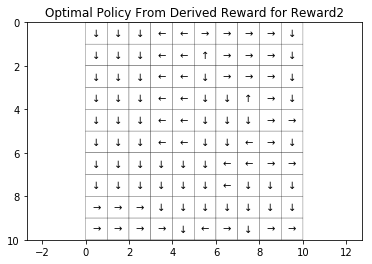

In [15]:
plot_policy_map(p_maxlambda_2, p_maxlambda_2_u, "Optimal Policy From Derived Reward for Reward2")

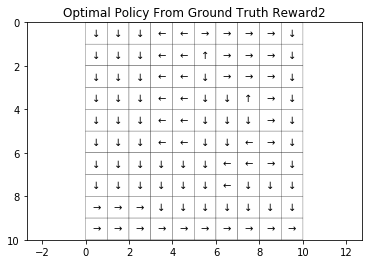

In [16]:
plot_policy_map(p_2, p_2_u, "Optimal Policy From Ground Truth Reward2")

In [17]:
diff_list = []
for i in range(len(p_2)):
    for j in range(len(p_2[0])):
        if (p_2[i][j] != p_maxlambda_2[i][j]):
            diff_list.append((i,j))

In [18]:
print(len(diff_list))

5


In [19]:
# Heat Map of the scaled differce in real and predicted rewards
# Optimal Value for Each State from Value Iteration using best lambda and predicted reward
v_ml_max = max(v_maxlambda_2.flatten())
v_ml_min = min(v_maxlambda_2.flatten())
v_max = max(v_2.flatten())
v_min = min(v_2.flatten())

v_maxlambda_2_scaled = (v_maxlambda_2 - v_ml_min)/(v_ml_max - v_ml_min)
v_2_scaled = (v_2 - v_min)/(v_max - v_min)

In [29]:
print ("Max and Min for actual values:\n", v_max, v_min)
print ("\nMax and Min for predicted values:\n", v_ml_max, v_ml_min)

Max and Min for actual values:
 47.311471068007975 -13.916634571058609

Max and Min for predicted values:
 485.797735663887 -16.029960271859125


Text(0.5, 1.0, 'Value Difference: (Predcited - Ground Truth)')

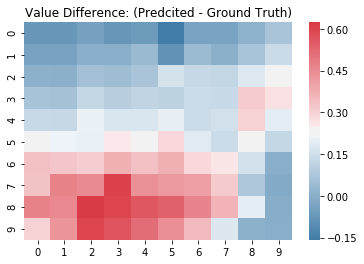

In [21]:
ax = sns.heatmap(v_maxlambda_2_scaled - v_2_scaled, cmap=sns.diverging_palette(240, 10, as_cmap=True))
ax.set_title("Value Difference: (Predcited - Ground Truth)")

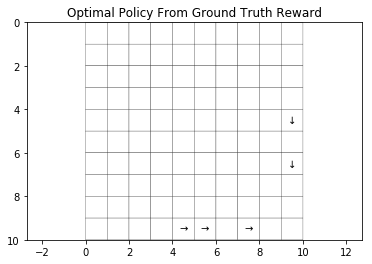

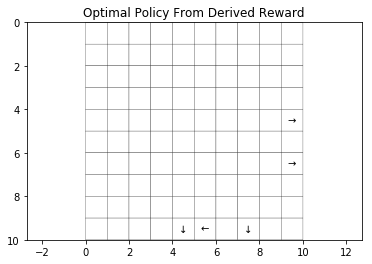

In [22]:
plot_optimal_policy_diff(p_2, "Optimal Policy From Ground Truth Reward", diff_list)
plot_optimal_policy_diff(p_maxlambda_2, "Optimal Policy From Derived Reward", diff_list)

In [49]:
thres = 0.000001
actions = [-10, -1, 10, 1]
w = 0.1
gamma = 0.8

In [50]:
v_maxlambda_2_flat = optimal_state_val(w, gamma, reward_opt2, thres)
v_maxlambda_2 = np.reshape(v_maxlambda_2_flat, (10,10)).T

p_maxlambda_2 = [0 for _ in range(100)]
p_maxlambda_2_u = [0 for _ in range(100)]
for state in range(100):
    p_maxlambda_2[state] = np.argmax([compute(state, 0, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 1, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 2, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 3, w, gamma, reward_opt2, v_maxlambda_2_flat)])
    p_maxlambda_2_u[state] = arrows[np.argmax([compute(state, 0, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 1, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 2, w, gamma, reward_opt2, v_maxlambda_2_flat),
                                   compute(state, 3, w, gamma, reward_opt2, v_maxlambda_2_flat)])]
    
p_maxlambda_2 = np.reshape(p_maxlambda_2, (10,10)).transpose()
p_maxlambda_2_u = np.reshape(p_maxlambda_2_u, (10,10)).transpose()

diff_list = []
for i in range(len(p_2)):
    for j in range(len(p_2[0])):
        if (p_2[i][j] != p_maxlambda_2[i][j]):
            diff_list.append((i,j))
            
print(len(diff_list))

0


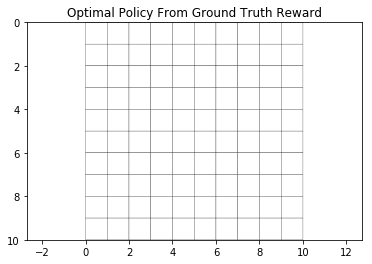

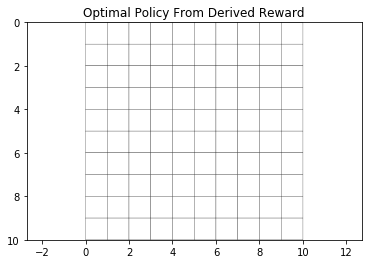

In [51]:
plot_optimal_policy_diff(p_2, "Optimal Policy From Ground Truth Reward", diff_list)
plot_optimal_policy_diff(p_maxlambda_2, "Optimal Policy From Derived Reward", diff_list)